In [119]:
import json
import os
import pickle
from langdetect import detect
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from urllib.parse import urljoin
from dotenv import load_dotenv
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style = 'white', palette = 'colorblind')

In [116]:
sns.__version__

'0.13.2'

# Read data from url

In [121]:
def fetch_json_from_url(url, depth=0):
    """Recursively fetch JSON files from given URL based on depth."""
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'lxml')
            for link in soup.select('tr.file a'):
                href = link['href'].strip()  # Strip whitespace from the href
                if href:
                    full_url = urljoin(url, href)

                    # Use regex to match dates and id in href and check depth conditions
                    if depth == 0 and re.search(r'\d{4}-\d{2}-\d{2}/$', href):
                        fetch_json_from_url(full_url, depth=1)
                    elif depth == 1 and re.search(r'\d+/$', href):
                        fetch_json_from_url(full_url, depth=2)
                    elif depth == 2 and href.endswith('.json'):
                        process_json_file(full_url)
        else:
            print(f"Failed to access {url}")
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")

def process_json_file(json_url):
    """Fetch and process a JSON file."""
    response = requests.get(json_url)
    if response.status_code == 200:
        data = response.json()
        all_jobs.append(data)
    else:
        print(f"Failed to retrieve JSON from {json_url}")

# Access the start url using the variable name defined in the .env file
load_dotenv()
start_url = os.getenv('START_URL')

# Fetch all jobs 
all_jobs = []
fetch_json_from_url(start_url)
raw_df = pd.DataFrame(all_jobs)
print(raw_df.head())

TypeError: file must have 'read' and 'readline' attributes

In [80]:
raw_df.describe()

,title,company,location,entity_urn,id,url,date,level,industries,employment_type,text,scrape_date
count,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020
unique,1085,917,230,2020,2020,2020,182,8,309,6,1740,14
top,Data Scientist,Haystack People,"Amsterdam, North Holland, Netherlands",urn:li:jobPosting:3475631966,3475631966,https://www.linkedin.com/jobs/view/3475631966,2024-07-05,Mid-Senior level,IT Services and IT Consulting,Full-time,Microsoft’s Health and Life Sciences team is d...,2024-07-12
freq,80,78,409,1,1,1,99,824,328,1866,12,751


In [81]:
columns_to_drop = ['entity_urn','id','url']
df=raw_df.drop(columns=columns_to_drop)
df.describe()

,title,company,location,date,level,industries,employment_type,text,scrape_date
count,2020,2020,2020,2020,2020,2020,2020,2020,2020
unique,1085,917,230,182,8,309,6,1740,14
top,Data Scientist,Haystack People,"Amsterdam, North Holland, Netherlands",2024-07-05,Mid-Senior level,IT Services and IT Consulting,Full-time,Microsoft’s Health and Life Sciences team is d...,2024-07-12
freq,80,78,409,99,824,328,1866,12,751


## Exploratory Data Analysis

In [83]:
df.isnull().sum()

title              0
company            0
location           0
date               0
level              0
industries         0
employment_type    0
text               0
scrape_date        0
dtype: int64

In [84]:
df[df['title']=='Data Scientist']['company'].value_counts()

Search X Recruitment                   7
Eminent Groep                          4
StarApple                              4
Vivid Resourcing                       3
Panda                                  3
Amoria Bond                            2
Jobs via eFinancialCareers             2
Medicine for Business                  2
FrieslandCampina                       2
Achmea                                 2
YER                                    2
Fractal                                2
BlockTech                              2
IG&H                                   2
Nationale Postcode Loterij             2
MetrixLab                              1
Elsevier                               1
Belastingdienst                        1
AniCura                                1
Inpact                                 1
Data Tribes                            1
VentureDive                            1
Digital Skills ltd                     1
Danone                                 1
ITsPeople       

In [85]:
df['industries'].value_counts()

IT Services and IT Consulting                                                                                       328
IT Services and IT Consulting, Software Development, and Computer and Network Security                              194
Staffing and Recruiting                                                                                             168
                                                                                                                    129
Software Development                                                                                                121
                                                                                                                   ... 
IT Services and IT Consulting, Civil Engineering, and Industrial Machinery Manufacturing                              1
Appliances, Electrical, and Electronics Manufacturing, Computer Hardware Manufacturing, and Software Development      1
IT Services and IT Consulting, Communica

In [86]:
df['level'].value_counts()

Mid-Senior level    824
Entry level         596
Associate           210
Not Applicable      171
                    166
Internship           47
Executive             3
Director              3
Name: level, dtype: int64

In [87]:
df['employment_type'].value_counts()

Full-time     1866
Contract       109
Part-time       24
Internship      12
Temporary        6
Other            3
Name: employment_type, dtype: int64

In [88]:
df['location'].value_counts()

Amsterdam, North Holland, Netherlands    409
Utrecht, Utrecht, Netherlands            144
Rotterdam, South Holland, Netherlands    121
Eindhoven, North Brabant, Netherlands     92
The Hague, South Holland, Netherlands     85
                                        ... 
De Rijp, North Holland, Netherlands        1
Soest, Utrecht, Netherlands                1
Tynaarlo, Drenthe, Netherlands             1
Ittervoort, Limburg, Netherlands           1
Beetsterzwaag, Friesland, Netherlands      1
Name: location, Length: 230, dtype: int64

In [89]:
df['title'].value_counts()

Data Scientist                                    80
Software Engineer                                 79
Python Developer                                  49
Senior Data Scientist                             25
Machine Learning Engineer                         24
                                                  ..
Software Engineer - Python/Golang - Kubernetes     1
Full-Stack Engineer (ID: 2046)                     1
Solidity Developer                                 1
Machine Learning engineer                          1
Junior Game Developer                              1
Name: title, Length: 1085, dtype: int64

In [90]:
df[df['date']>'2024-06-11']['date'].value_counts().sort_index(ascending=False)

2024-07-24     4
2024-07-23    36
2024-07-22    55
2024-07-21    96
2024-07-20    17
2024-07-19    46
2024-07-18    99
2024-07-17    73
2024-07-16    80
2024-07-15    69
2024-07-14    88
2024-07-13    18
2024-07-12    87
2024-07-11    62
2024-07-10    59
2024-07-09    53
2024-07-08    37
2024-07-07     3
2024-07-06    10
2024-07-05    99
2024-07-04    52
2024-07-03    47
2024-07-02    34
2024-07-01    52
2024-06-30     2
2024-06-29    15
2024-06-28    38
2024-06-27    26
2024-06-26    36
2024-06-25    32
2024-06-24    38
2024-06-23     4
2024-06-22    29
2024-06-21    26
2024-06-20    26
2024-06-19    26
2024-06-18    25
2024-06-17    22
2024-06-16     1
2024-06-15     7
2024-06-14    10
2024-06-13    27
2024-06-12     9
Name: date, dtype: int64

/var/folders/w8/ykvcb98x72b0lxq2zjgfnbd80000gn/T/ipykernel_8016/4195138697.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=top_categories, stat='percent', palette="viridis")


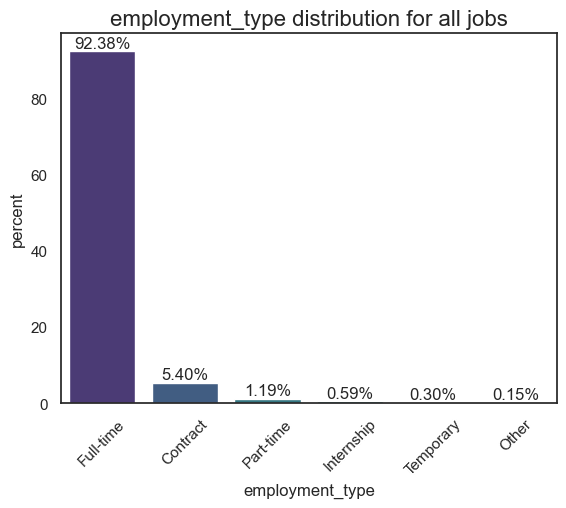

In [91]:
# Function to plot the distribution of categorical data
def cat_plot(col,df=df, top_n=8):
    n = df[col].nunique()
    plot_n = min(top_n,n)
    top_categories = df[col].value_counts().head(plot_n).index
    ax = sns.countplot(data=df, x=col, order=top_categories, stat='percent', palette="viridis")

    ax.set_title(f"{col} distribution for all jobs",fontsize=16)
    #ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
    #ax.get_xticklabels(set_rotation=60)
    #ax.set_tick_params(rotation=30, labelsize=10)
    # ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)
    ax.tick_params(axis='x', rotation=45)


    for bars in ax.containers:
        ax.bar_label(bars, fmt='{:.2f}%')

    return None

cat_plot(col='employment_type')


## Preprocess text data 

In [343]:
import re

def preprocess_text(text):
    # Define exceptions in a way that regex checks for word boundaries around them
    exceptions = r"\b(?:NumPy|TensorFlow|MatPlotLib)\b"  # Using non-capturing group and word boundaries

    # Use a callback function in re.sub to handle complex logic
    def replace(match):
        # If the matched string is in the exceptions, return it as is
        if re.search(exceptions, match.group(0)):
            return match.group(0)
        # Otherwise, add a period if it's a letter transition
        return match.group(1) + '. ' + match.group(2)

    # Match a lowercase letter followed by an uppercase letter with possible exception handling
    text = re.sub(r'([a-z])([A-Z])', replace, text)

    # Insert a period after specified punctuation if followed directly by a capital letter
    text = re.sub(r'([)\]:;])([A-Z])', r'\1. \2', text)

    return text

# Example usage
text = "We use NumPy and TensorFlow for data analysis. Peter Hardy (Director)What we ask: MSc degree in Econometrics; Data Science"
processed_text = preprocess_text(text)
print(processed_text)


We use Num. Py and Tensor. Flow for data analysis. Peter Hardy (Director). What we ask: MSc degree in Econometrics; Data Science


In [316]:
df['processed_text'] = df['text'].apply(preprocess_text)

In [92]:
def lang_detect(text):
    try:
        ln = detect(text)
    except:
        ln = None
    return ln

df['language'] = df['text'].apply(lambda x: lang_detect(x)) 

## Analysis of language requirement 

### Determine language requriment from text 

In [93]:
df['language'].value_counts()

nl       1036
en        969
pl         10
zh-cn       2
de          1
fr          1
pt          1
Name: language, dtype: int64

In [94]:
df_english_text = df[df['language'] == 'en'].copy()
df_english_text['dutch_mention'] = df_english_text['text'].str.contains('dutch', case=False)
df_english_text['dutch_mention']

1        True
2       False
3       False
4        True
5        True
        ...  
2012     True
2013     True
2014    False
2015    False
2019    False
Name: dutch_mention, Length: 969, dtype: bool

In [95]:
text = "This inclusive employer is a member of myGwork \u2013 the largest global platform for the LGBTQ+ business community dutch.\n   At Booking.com, dutch data drives our decisions. Technology is at our core. And innovation is everywhere. But our company is more than datasets, lines of code or A/B tests. We\u2019re the thrill of the first night in a new place. The excitement of the next morning. The friends you make. The journeys you take. The sights you see. And the food you sample. Through our products, partners and people, we can empower everyone to experience the world. \nRole description \n \n \nAs a Data Scientist in the Experimentation Science Team, you focus on scalable solutions to the company\u2019s most persistent challenges in decision making. You provide support to experimenters across the company, investigate problems and define clear solutions and requirements for their implementation, build proofs of concept and prototypes, and work closely with the engineering teams to support our product vision. The ability to write high quality, reproducible code and dig into technical product details and data pipelines is crucial to make your work impactfully landed in the Experimentation Tool, and enable solid decision making adoptable by a wide range of experimenters! \n \nAs a Data Scientist II, you\u2019ll take full ownership of the design and delivery of data science solutions, from ideation to implementation. You are expected to combine sound business understanding, data handling, programming, statistical modeling and data visualization to derive actionable information from broad sets of data while valuing pragmatism over perfection. \nIn the meantime, you are also part of a data science team, and work with partners throughout the company, to generate understanding, strategy and guide key decision making based on data. It involves applying suitable statistical data analysis and modeling methods to solve sophisticated business problems, independently identify and lead partners, and effectively communicate complex analysis results. \n \n \nKey Job Responsibilities And Duties \n \nResponsible for owning the design and delivery of entire Data Science solutions based on business requirements, bringing them from the initial idea-generation phase to implementation independently. \nResponsible for working autonomously on consuming data, preparing it for data science use, translating business problems to data stories and solving them effectively by applying suitable statistical data analysis and modeling methods. Leverages input from business stakeholders in all of the above to determine the right technical solutions to deliver customer value. \nResponsible for working primarily within the scope of their team to deliver work that informs business decisions for the product / business topic they currently work on, occasionally collaborating across multiple teams.  \nResponsible for designing and interpreting quantitative experiments to objectively guide key business decision making. \nResponsible for independently identifying and handling stakeholders in operational, project-based, and managerial roles. Effectively communicates, addresses collaborators' needs, and conveys complex analysis results in a clear manner. Begins to guide junior colleagues in stakeholder engagement. \nResponsible for being flexible in adopting existing internal and external Data Science approaches, proposing and spotting opportunities to apply new approaches and expanding their technical competencies and their peer\u2019s when a more efficient way presents itself. \nResponsible for leveraging Data Science for impact while learning to incorporate scalability, reproducibility and long term orientation in their work.  \nResponsible for acting as a force multiplier for junior peers in the team by actively helping them with their craft through means of coaching, mentoring and setting a good example. \nResponsible for contributing to the community of their area by supporting community projects aimed at making other data professional more effective, actively participating in community strengthening activities (ie. recruitment) and connecting with peers beyond their area. \nResponsible for collaborating with peers in related crafts (ie. Data Engineering), anticipating data needs to ensure smooth progress of their individual projects. \nResponsible for ensuring quality of their own work by validating it through peer review. \nResponsible for influencing business decisions within their specific area (ie. product team) \n \n \nRole Qualifications And Requirements \n \nProficient in Pyspark and general Python \nSolid understanding of statistical and hypothesis testing \nExperience working closely with product teams (not just PMs, but directly with developers/engineers) \nWillingness to dig deep into problems and behind the scenes data to support troubleshooting/bug fixing \nSolution oriented and result driven \nAble to brainstorm, peer review and drive research topics benefit Experimentation and Decision Making in both short and long term \nExcellent English communication skills, both written and verbal; the ability to convey your message to team members and other partners, clearly and gently. \nAchieve impacts as a great teammate, and maintain solid relationships with technical and non technical collaborators. \n \n \nThe Following Skills Are Assets For This Role \n \nKnowledgeable about statistical properties of (good) metrics, and ability to scalably test them \nCausal inference knowledge beyond A/B testing \nUnderstand the gist of scripts written in R \nExperience building libraries/modules in python \nFamiliarity with apis using is good, building/maintaining is great \nGood understanding of fundamental machine learning concepts \nSolid understanding of reporting/visualization techniques (e.g., Tableau, Graphite, Power BI, etc.) \n \n \nDEI: Diversity, Equity and Inclusion at Booking.com \n \nDiversity, Equity and Inclusion (DEI) have been a core part of our company culture since day one. This ongoing journey starts with our very own employees, who represent over 140 nationalities and a wide range of ethnic and social backgrounds, genders and sexual orientations. Take it from our Chief People Officer, Paulo Pisano: \u201cAt Booking.com, the diversity of our people doesn\u2019t just create a unique workplace, it also creates a better and more inclusive travel experience for everyone.\u201d \nWe will ensure that individuals with disabilities are provided reasonable adjustments to participate in the interview process. Please contact us to request adjustments. \n \n \nCareer Development Opportunities \n \nBi-annual performance conversations, company-wide mentoring program, and internal development opportunities \nUnlimited access to online learning platforms: Udemy, Coursera, LinkedIn learning, O'reilly \n \n \nApplication Process \n \nThe interview process for this role entails a total of 3 interviews. \n \n \nBooking.com is proud to be an equal opportunity workplace and is an affirmative action employer. All qualified applicants will receive consideration for employment without regard to race, color, religion, gender, gender identity or expression, sexual orientation, national origin, genetics, disability, age, or veteran status. We strive to move well beyond traditional equal opportunity and work to create an environment that allows everyone to thrive. \n \nPre-Employment Screening \n \nIf your application is successful, your personal data may be used for a pre-employment screening check by a third party as permitted by applicable law. Depending on the vacancy and applicable law, a pre-employment screening may include employment history, education and other information (such as media information) that may be necessary for determining your qualifications and suitability for the position."

In [102]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_dutch_sentences(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents if 'dutch' in sent.text.lower()]
    return ' '.join(sentences)
    #return sentences

In [103]:
print(extract_dutch_sentences(text))

This inclusive employer is a member of myGwork – the largest global platform for the LGBTQ+ business community dutch.
    At Booking.com, dutch data drives our decisions.


In [104]:
df_english_text['sentences_with_dutch'] = df_english_text['text'].apply(extract_dutch_sentences)

In [99]:
pd.set_option('display.max_colwidth', None) 

In [105]:
df_english_text['sentences_with_dutch'].sample(10)

825                                                                                        The Dutch government provides substantial tax benefits for five years, as well as financial child support..
416                                                                                                                                                                                                   
409                                                                                                                                                                                                   
1151                                                                                                                                                                                                  
1833                                                                                                                                                                                                  
594  

In [107]:
sample_sentences = df_english_text[df_english_text['sentences_with_dutch'].astype(bool)]['sentences_with_dutch'].sample(10)
sample_sentences

1777                                                                                                                                                                                                  Fluent in English and Dutch. . .
1219                     REF NL is considered to be the principal Dutch real estate lender, and our real estate knowledge is appreciated throughout the real estate investor market. You are fluent in English, Dutch is a pre.. . . .
593                                                                                              Going Dutch. . We go by the Dutch law and start with a 12-month contract with the intent to offer a permanent contract afterwards.. .
333                                                                    You are currently living in Amsterdam and enrolled as a student on a Dutch University or doing the Erasmus course in Business Administration or related fields.
423                                                                         

In [113]:
from openai import OpenAI

# Helper function to get generated outputs from OpenAI model 
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def get_completion(prompt, model='gpt-4'):
    messages = [{ "role": "user", "content": prompt }]
    response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=0,
        )
    return response.choices[0].message.content

# Fuction to determine if the text requires dutch language  
def determine_dutch_requirment(text):

    prompt = f"""
    Your task is to determine if the job description {text} requires Dutch language. Please return your
    answer from the list ['Dutch required', 'Dutch is an asset', 'Other']
    """

    try:
        dutch_requirement = get_completion(prompt)
        return dutch_requirement
    except Exception as e:
        print(f"An error occured: {e}")
        return []


In [114]:
for sent in test:
    response = determine_dutch_requirment(sent)
    print(f"{sent}:{response}")

REF NL is considered to be the principal Dutch real estate lender, and our real estate knowledge is appreciated throughout the real estate investor market. You are fluent in English, Dutch is a pre.. . . .:'Dutch is an asset'
Language fluency in English AND French or German or Dutch.:'Dutch is an asset'


In [336]:
997 in df_english_text.index

False

In [334]:
df_english_text.iloc[997]

IndexError: single positional indexer is out-of-bounds

In [314]:
sent='REF NL is considered to be the principal Dutch real estate lender, and our real estate knowledge is appreciated throughout the real estate investor market. You are fluent in English, Dutch is a pre.Rewards & Benefits.'
determine_dutch_requirment(sent)

'Based on the job description provided, the requirement for Dutch language is explicitly mentioned as "requires Dutch language." Therefore, the appropriate answer from the list is:\n\n\'Dutch required\''

In [253]:
print(sample_sentences_response)

['Dutch required',
 'Dutch is an asset',
 'Dutch is an asset',
 'Dutch is an asset',
 'Dutch is an asset',
 'Dutch required',
 'Dutch is an asset',
 'Dutch is an asset',
 'Other',
 'Other']

In [238]:
df_english_text['dutch_requirment'] = df_english_text['sentences_with_dutch'].apply(determine_dutch_requirment)

KeyboardInterrupt: 

In [200]:
# Determine if entries are in English based on 'language' and absence of 'dutch' in 'text'
df['is_english'] = ((df['language']=='en') & (~ df['text'].str.contains('dutch',case=False)))

In [201]:
df['is_english'].value_counts()

False    761
True     421
Name: is_english, dtype: int64

In [ ]:
df['week'] = df['date']

/Users/jianisong/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


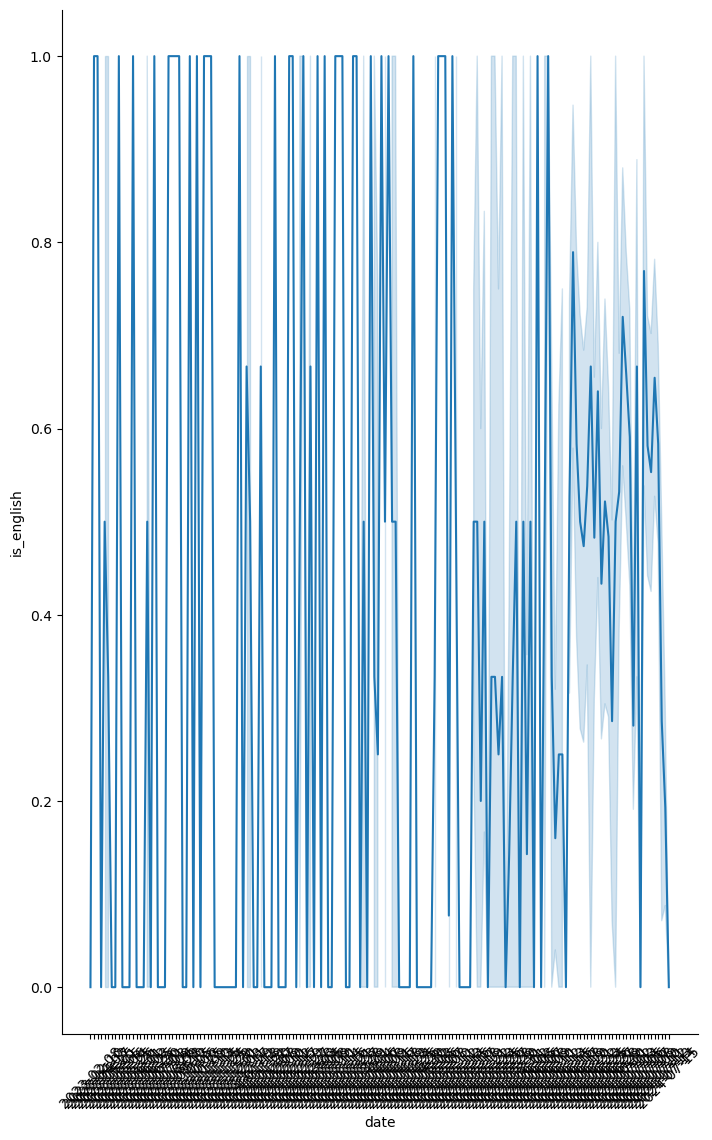

In [186]:
g = sns.relplot(data=df, x = 'date', y='is_english', kind='line')
g.figure.set_size_inches(8, 12)  
g.set_xticklabels(rotation=45)

### Analyze job titles

In [166]:
df['title'].unique()

array(['Mobile app (iOS/Android) developer | Gamebasics',
       'Software Engineer', 'Lead Machine Learning Engineer',
       'Full Stack Developer', 'Metaverse Engineer',
       'Unreal Engine Developers', 'Software Engineer Traineeship',
       'Natural Language Processing Engineer',
       'Full Stack Software Engineer | Rotterdam | Navara',
       'Full Stack Software Engineer | Amsterdam | Navara',
       'Data Scientist | Freshminds Data', 'Python Developer',
       'Data Scientist | Qualogy Solutions', 'Data scientist | Valcon NL',
       'Traineeship Data Science & Engineering | Educom',
       'Python Developer - Capelle a/d IJssel | ALTEN',
       'Python Developer | Alteza',
       'Data Scientist | Active Professionals',
       'Senior Machine Learning Engineer', 'Strategic Data Scientist',
       'Junior Software Engineer',
       'Python Developer - Amstelveen | ALTEN', 'SDE-ZY', 'SDE-供应商开发工程师',
       'Mendix App developer', 'Python developer (Tesla bedrijfswagen)',
   

In [167]:
from translate import Translator

#translator = Translator(from_lang="nl", to_lang="en")

def translate_text(text, language):
    try:
        translator = Translator(from_lang=language, to_lang="en")
        translation = translator.translate(text)
        return translation
    except Exception as e:
        print(f"An error occurred: {e}")
        return text
    
def get_english(text):
    language = lang_detect(text)
    if language =='en':
        return text
    else:
        return translate_text(text,language)

df['english_title'] = df['title'].apply(get_english)

In [168]:
# Function to group job titles
def group_title (title):
    title_lower = title.lower()
    if ('scientist' in title_lower) or ('data science' in title_lower):
        return 'Data Scientist'
    elif 'machine learning' in title_lower:
        return 'Machine Learning Engineer'
    elif 'developer' in title_lower:
        return 'Developer'
    # elif 'python' in title_lower:
    #     return 'Python Developer'
    elif 'engineer' in title_lower:
        return 'Engineer'
    else:
        return 'Other'

df['title_group'] = df['english_title'].apply(group_title)

print(df[['title','title_group']])

                                                title  \
0     Mobile app (iOS/Android) developer | Gamebasics   
1                                   Software Engineer   
2                      Lead Machine Learning Engineer   
3                                Full Stack Developer   
4                                  Metaverse Engineer   
...                                               ...   
1177                                 Python Developer   
1178          Senior Software Engineer (C++ / Python)   
1179                                   Data Scientist   
1180                                   Data Scientist   
1181               Senior Full Stack Python Developer   

                    title_group  
0                     Developer  
1                      Engineer  
2     Machine Learning Engineer  
3                     Developer  
4                      Engineer  
...                         ...  
1177                  Developer  
1178                   Engineer  
1179     

In [169]:
df['title_group'].value_counts()

Engineer                     471
Developer                    320
Data Scientist               270
Machine Learning Engineer     69
Other                         52
Name: title_group, dtype: int64

In [170]:
df[df['title_group']=='Other']['title'].value_counts()

Engineer                                                                                                                4
Robot Programmeur, Warmenhuizen                                                                                         3
Reliability Programmeur, Wieringerwerf                                                                                  2
Programmeur, Den Haag                                                                                                   2
Stanowisko ds. rozliczeń                                                                                                2
Stanowisko ds. egzekucji                                                                                                2
AI / Neuromorphic Researcher                                                                                            2
SDE-ZY                                                                                                                  1
PLC progammeur          

/Users/jianisong/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


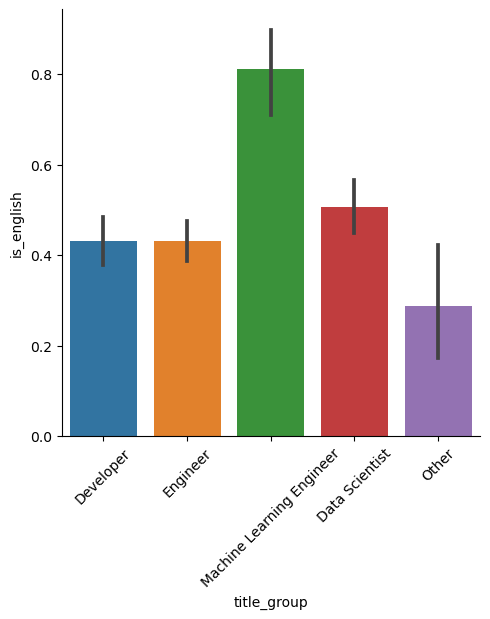

In [172]:
import seaborn as sns
g = sns.catplot(data=df, x = 'title_group', y='is_english', kind='bar')
g.set_xticklabels(rotation=45)